# Hurricane Impact: interactive mapping using Folium and Leaflet.

In this exercise, we provide an example of the use of leafleft for interactive mapping. We will visualize changes following hurricane RITA using teh MODIS Terra sensor (MOD09 product). Hurrican Rita was a category 3 hurricane that landed on September 24, 2005 in the region between the state of Louisiana and Texas. It generated important flooding with surge of more than 4 meters in some areas.

## Documentation and packages

First, we set up the code by providing information on the Authors, Creation dates, version by importing relevant python packages. Documenting and providing context and information within a script is important as it is often the case that code will be reused for other applications or other users/colleagues Good documentation improves code reproducibility as well.

In [34]:
#################################### Geovisulization: Interactive Mapping #######################################
######################## Hurricane RITA impact #######################################
#This script performs analyses to predict air temperature using several coveriates.
#The goal is to predict air temperature using Remotely Sensing data as well as compare measurements
# from the ground station to the remotely sensed measurements.
#
#AUTHORS: Benoit Parmentier
#DATE CREATED: 04/24/2019
#DATE MODIFIED: 04/24/2019
#Version: 1
#PROJECT: General data science training, SESYNC Geospatial Course, AAG 2019 Python Geospatial Course
#TO DO:
#
#COMMIT: modif of code
#
#################################################################################################

###### Library used in this script
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns
import rasterio
import subprocess
import pandas as pd
import os, glob
from rasterio import plot
import geopandas as gpd
import georasters as gr
import gdal
import rasterio
import descartes
import pysal as ps
#from cartopy import crs as ccrs
from pyproj import Proj
from osgeo import osr
from shapely.geometry import Point
from collections import OrderedDict
import webcolors
import sklearn
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split
from sklearn import metrics
import folium
from folium import plugins


The packages above are some of the most frequently used for geospatial data processing, wrangling and analysis. Notables packages are geopandas, rasterio, pysal, gdal and shapely. Geopandas extends the pandas package to allow for the use of spatial data using a geometry column in a DataFrame. It implements a version of the Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allows operations and processing on raster layers. Pysal provide spatial analyses tools such as Moran's I and spatial regression modeling. In this exercise, we also use the "sklearn" package that contains some of the most widely known machine learning and regression models (e.g. OLS linear regression, randomForest, svm etc.).  

## Functions

In the next part of the script, we declare all the functions used in the sripts. The first function builds outputs directory while the second function helps in the fitting and testing of the regression model. It is good practice to place functions at the beginning of a script or an external source file.

In [21]:

################ NOW FUNCTIONS  ###################

##------------------
# Functions used in the script
##------------------

def create_dir_and_check_existence(path):
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")



## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).

In [22]:
############################################################################
#####  Parameters and argument set up ###########

#ARGS 1
in_dir = "/nfs/public-data/cyberhelp/blogs/raster-change-analysis"
#ARGS 2
out_dir = "/research-home/bparmentier"

#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARGS 4
out_suffix = "exercise5_change_04052019" #output suffix for the files and ouptut folder
#ARGS 5
NA_value = -9999 # number of cores
#ARGS 6
file_format = ".tif"
#ARGS 7
#CRS_reg = "+proj=aea +lat_1=29.5 +lat_2=45.5 +lat_0=23 +lon_0=-96 +x_0=0 +y_0=0 +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs"
#ARGS 8
infile_reflectance_date1 = "mosaiced_MOD09A1_A2005265__006_reflectance_masked_RITA_reg_1km.tif" #date 1 image
#ARGS 9
infile_reflectance_date2 = "mosaiced_MOD09A1_A2005273__006_reflectance_masked_RITA_reg_1km.tif" #date 2 image
#ARGS 10
infile_reg_outline = "new_strata_rita_10282017.shp" #region outline and FEMA data


## Input and output directories

Before any analyses, we start the script by creating a new output directory to store new files generated througout the script. Separating inputs from outputs avoids overwriting or modifiying the input source files. It is likely that you will repeath the analyses multiples times and generating a new output directory with a date or version can also help in tracking modeling and analyses outputs with different input arguments. 

In [23]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    #out_path<-"/data/project/layers/commons/data_workflow/output_data"
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(create_out_dir) #use working dir defined earlier

directory already exists


## Reading and visualizing data

Part I consists in reading in weather stations data in geopandas DataFrame and loading raster images from MODIS in rasterio objects. We explore the datasets by examining the coordinate systems, size (use "shape") and by displaying a few rows of the new geopanda data frame.

In [40]:
###########################################
### PART I: READ AND VISUALIZE DATA #######

######### PART 0: Set up the output dir ################

r_before = rasterio.open(os.path.join(in_dir,infile_reflectance_date1)) # Before RITA, Sept. 22, 2005.
r_after = rasterio.open(os.path.join(in_dir,infile_reflectance_date2)) # After RITA, Sept 30, 2005.

#names(r_before) <- c("Red","NIR","Blue","Green","SWIR1","SWIR2","SWIR3")
#names(r_after) <- c("Red","NIR","Blue","Green","SWIR1","SWIR2","SWIR3")

#plot(r_before)

reg_gdf = gpd.read_file(os.path.join(in_dir,infile_reg_outline))
os.path.join(in_dir,infile_reg_outline)
print("Coordinate reference system: ",r_before.crs ) 
      
reg_gdf.head()  
reg_gdf.crs = {'init' :'epsg:4326'}

print("Bounding box: ",reg_gdf.total_bounds)
#[ -1.57239292  50.57467674   0.14528384  51.27465152]

xmin, ymin, xmax, ymax = reg_gdf.total_bounds
#sac_sussex = df_sac.cx[xmin:xmax, ymin:ymax]

# crs=3857 #only web mercator right now for raster
#pal <- colorNumeric("PiYG",values(r_before$Red),na.color = "transparent")
#pal <- colorNumeric("PiYG", wbd_reg2$AREA)

#https://cyberhelp.sesync.org/leaflet-in-R-lesson/2019/03/27/
#https://rstudio.github.io/leaflet/raster.html
#https://www.earthdatascience.org/courses/earth-analytics-python/lidar-raster-data/interactive-maps/
# Create a map using Stamen Terrain, centered on study area with set zoom level
# -92.5059 29.98144

m = folium.Map(location=[29.98144, -92.5059],
                   tiles='Stamen Terrain', zoom_start = 3)
m

Coordinate reference system:  PROJCS["unnamed",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.2572221010042,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["standard_parallel_1",27.41666666666667],PARAMETER["standard_parallel_2",34.91666666666666],PARAMETER["latitude_of_origin",31.16666666666667],PARAMETER["central_meridian",-100],PARAMETER["false_easting",1000000],PARAMETER["false_northing",1000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Bounding box:  [-93.929208  29.472362 -91.082602  30.490523]


Rasterio provides easy tools to display raster images. We compare the distributio of LST temperatures for the month of July and January.


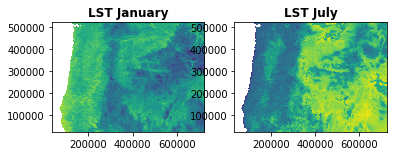

In [7]:
# Use rasterio to import the reprojected data as img
with rasterio.open(os.path.join(in_dir,infile_reflectance_date1)) as src:
    boundary = src.bounds
    img = src.read()
    nodata = src.nodata
    
# Overlay raster called img using add_child() function (opacity and bounding box set)
#m.add_child(plugins.ImageOverlay(img[0], opacity=.7, 
#                                 bounds =[[40.05577828237005, -105.32837712340124], [40.073923431943214, -105.28139535136515]]))

m.add_child(plugins.ImageOverlay(img[0], opacity=.7))
            
# Display map
m


To manipulate raster data, we read in raster bands directly in numpy arrays and visualize the information. Once, we have arrays, we can perform most of the map algebra or arithmetical operations. We examine differences in temperature between July and January and create a new image (numpy array). From the map display, we can see that larger differences occurs in the eastern part of Oregon. Note that reading raster imagery in arrays may be problematic when we have large images. Alternatives may be to use GDAL tools such gdalcalc to perform map algebra and arithmetical operations as GDAL does not require reading information in memory directly.

Data type for r_lst1 object:  <class 'numpy.ma.core.MaskedArray'>


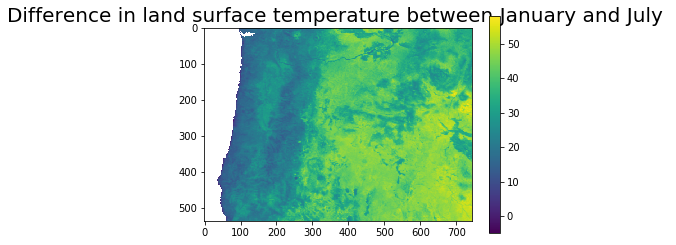

In [8]:
## Read raster bands directly to Numpy arrays and visualize data
r_lst1 = lst1.read(1,masked=True) #read first array with masked value, nan are assigned for NA
r_lst7 = lst7.read(1,masked=True) #read first array with masked value, nan are assigned for NA

spatial_extent = rasterio.plot.plotting_extent(lst1)
print("Data type for r_lst1 object: ",type(r_lst1))
r_lst1.size

r_diff = r_lst7 - r_lst1
plt.imshow(r_diff);
# other way to display data
plt.title("Difference in land surface temperature between January and July ", fontsize= 20)
plt.colorbar()


It is also useful to examine temperature distribution for January and July using histograms (we use the matplotlib package). Note that we had to extend the the limits of values for the LST temperatures since LST values are substantially higher for July. 

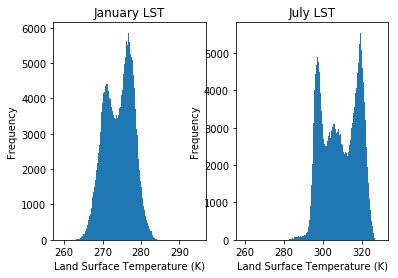

In [9]:
# Explore values distribution
f, ax = plt.subplots(1, 2)
ax[0].hist(r_lst1.ravel(),
         bins=256,
         range=(259.0,295.0));
ax[0].set_title('January LST')
ax[0].set_xlabel('Land Surface Temperature (K)')
ax[0].set_ylabel('Frequency')

ax[1].hist(r_lst7.ravel(),
         bins=256,
         range=(259.0,330));
ax[1].set_title('July LST')
ax[1].set_xlabel('Land Surface Temperature (K)')
ax[1].set_ylabel('Frequency')

# Combine raster and vector layers on same plot

It is often useful to display both vector and raster layers on the same plot. This can be done using the rasterio package or the standard matplotlib utility. We must first generate a "ax" plot object to add a layer on a existing plot figure.

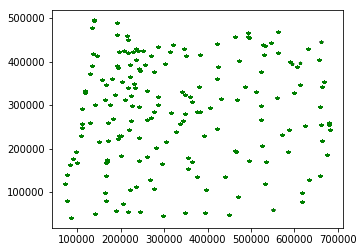

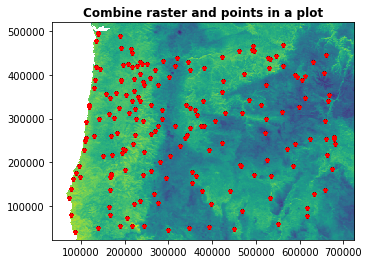

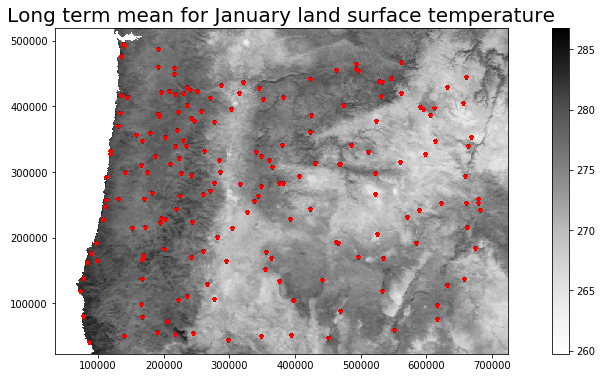

In [10]:
##### Combine raster layer and geogpanda layer

data_gpd.plot(marker="*",color="green",markersize=5)
station_or = data_gpd.to_crs({'init': 'epsg:2991'}) #reproject to  match the  raster image

##### How to combine plots with rasterio package
fig, ax = plt.subplots()
rasterio.plot.show(lst1,ax=ax,
                          clim=(259.0,287.0),
                  title="Combine raster and points in a plot")
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
               
##### How to combine plots with matplotlib package
fig, ax = plt.subplots(figsize = (16,6))
lst_plot = ax.imshow(r_lst1, 
                       cmap='Greys', 
                       extent=spatial_extent)
station_or.plot(ax=ax,marker="*",
              color="red",
               markersize=10)
ax.set_title("Long term mean for January land surface temperature", fontsize= 20)
fig.colorbar(lst_plot)


The values extracted are in Kelvin degree and are repeated in each row. We convert values in degree C, and remove no data values (flag value is -9999). We compute averages at each weather station using the "groupby" pandas operator.The goal is to generate unique monthly LST values for each station. Note that we also need to rescale the GHCN network values to have comparable LST and ground measurements.

We use the "linear_model" tool from the sklearn package to istantiate a modeling object. Fitting is provived by the general fit method and prediction on dataset can be obtained using the predict method.

## Conclusions

This exercise explored the use of leaflet with folium for geovisualization and interactive mapping. We used two satellite images to explore the impact of hurrican RITA in the landscape.
We were able to visualize flooding from NDVI.

## References

For an example of a research study on hurricane impact: Hurricane disturbance mapping using MODIS EVI data in the southeastern Yucatán, Mexico John Rogan , Laura Schneider , Zachary Christman , Marco Millones , Deborah Lawrence & Birgit Schmook Pages 259-267 | Received 12 Jun 2010, Accepted 28 Aug 2010, Published online: 29 Oct 2010 Download citation https://doi.org/10.1080/01431161.2010.520344
